In [2]:
# !pip install datasets fasttext evaluate
import os
import subprocess
import kagglehub
import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict, Features, Value, ClassLabel
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.under_sampling import RandomUnderSampler
import spacy
import spacy.cli
import fasttext.util as fasttext_util
import fasttext
from collections import Counter
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import tqdm
import pickle
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import evaluate
import warnings
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
from importnb import Notebook

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings("ignore")

/Users/henrybaker/miniconda3/envs/nlp_1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [2]:
# DATA

DATA_DIR = "./data"
INFERENCE_DATA = "./data/inference_data.csv"

if os.path.exists(INFERENCE_DATA):
    print("Loading data")
    inference_df = pd.read_csv("./data/inference_data.csv")
else:
    os.makedirs(DATA_DIR, exist_ok=True)
    print("calling data proicessing script")
    
    # Calling the Jupyter notebook script
    subprocess.run(['jupyter', 'nbconvert', '--execute', '--to', 'notebook', '--inplace', '1_data_processing.ipynb'])

Loading data


# Transformer Inference

In [ ]:
# TRANSFORMER INFERENCE ================================================================
model_path = "./models/transformer_results"
bert_tokenizer = AutoTokenizer.from_pretrained(model_path)
bert_uncased = AutoModelForSequenceClassification.from_pretrained(model_path)

# Tokenize climate tweets
CLIMATE_TOKENISED_BERT_DIR = './cache/climate_tokenised_bert.pkl'

if os.path.exists(CLIMATE_TOKENISED_BERT_DIR):
    print("Tokenized climate tweets pkl file found. Loading data...")
    with open(CLIMATE_TOKENISED_BERT_DIR, 'rb') as f:
        climate_tokenised_bert = pickle.load(f)
else:
    print("Pickle file not found. Tokenizing climate tweets...")
    climate_tokenised_bert = bert_tokenizer(
        list(inference_df["text"]),  
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors="pt"
    )
    with open(CLIMATE_TOKENISED_BERT_DIR, 'wb') as f:
        pickle.dump(climate_tokenised_bert, f)
    print("Tokenized climate tweets and saved to file.")

# Predict using fine-tuned Transformer model
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

def predict_climate_tweets(model, tokenized_texts, batch_size=32, device='mps'):
    model.to(device)
    model.eval()

    predictions = []
    with torch.no_grad():
        for i in range(0, len(tokenized_texts['input_ids']), batch_size):
            batch_input_ids = tokenized_texts['input_ids'][i:i + batch_size].to(device)
            batch_attention_mask = tokenized_texts['attention_mask'][i:i + batch_size].to(device)

            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            preds = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_labels = torch.argmax(preds, dim=1)
            predictions.extend(predicted_labels.cpu().numpy())

    return predictions

predicted_labels_transformer = predict_climate_tweets(bert_uncased, climate_tokenised_bert, batch_size=32, device=device)

# predicted labels
inference_df['predicted_label_transformer'] = predicted_labels_transformer
inference_df['predicted_label_transformer'] = inference_df['predicted_label_transformer'].replace({0: 'factual', 1: 'misinformation'})

Tokenized climate tweets pkl file found. Loading data...
Using device: mps


Transformer Inference: 
Distribution of 'factual' vs 'misinformation' predictions:
predicted_label_transformer
factual           13864
misinformation     5186
Name: count, dtype: int64


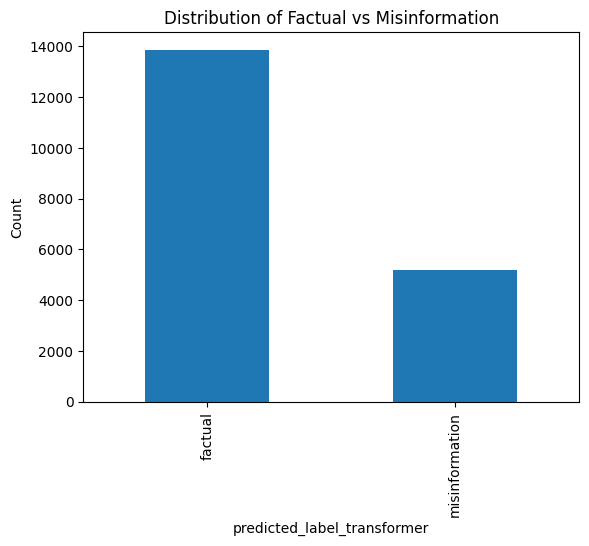

In [9]:
# Count occurrences of each label
label_counts = inference_df['predicted_label_transformer'].value_counts()

print("Transformer Inference: \nDistribution of 'factual' vs 'misinformation' predictions:")
print(label_counts)

label_counts.plot(kind='bar')
plt.title('Distribution of Factual vs Misinformation')

plt.ylabel('Count')
plt.show()

# Non-Transfomer Inference

Choose top performer

In [ ]:
# loading model & tokeniser -------

from model_architectures import BidirectionalGRUTextClassifier

TOP_MODEL_PATH = "./models/bidirectional_gru_model.pth"
RNN_BASED_MODEL = torch.load(TOP_MODEL_PATH)

with open("./cache/rnn_tokenizer_file.pkl", "rb") as f:
    RNN_TOKENISER = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: './models/bidirectional_gru_model.pth'

In [1]:
# load helper functions 

from tokenizer_helper_fns import batch_tokenize, custom_analyzer, vocab_mapping
from data_loader_helper_fns import collate_fn

# pipeline for GRU/RNNs etc ==========

TOKENIZER_FILEPATH = './cache/rnn_tokenizer_file.pkl'
INFERENCE_TOKENISED_FILEPATH = './cache/climate_tokenised_rnn.pkl'

if os.path.exists(INFERENCE_TOKENISED_FILEPATH):
    with open(INFERENCE_TOKENISED_FILEPATH, 'rb') as f:
        climate_tokenised_rnn = pickle.load(f)
    print(f"Tokenized climate tweets pkl file found. Loading data...")
else:    
    with open(TOKENIZER_FILEPATH, 'rb') as f:
        rnn_tokenizer = pickle.load(f)
        
    climate_tokenised_rnn = batch_tokenize(
        inference_df["text"],
        32,
        lambda text: custom_analyzer(text, trained_tokenizer=rnn_tokenizer)
    )
    # Convert to dictionaries with keys: "input_ids", "attention_mask"
    climate_tokenised = [
        {
            "input_ids": encoding.ids,
            "attention_mask": encoding.attention_mask,
        }
        for encoding in climate_tokenised_rnn
    ]
    # save tokenised text
    with open(INFERENCE_TOKENISED_FILEPATH, 'wb') as f:
        pickle.dump(climate_tokenised_rnn, f)

# VOCAB MAPPING ---------------------------------------------------------------------------------------------------
vocab_idx = vocab_mapping(tokenized_text=climate_tokenised) 

# CREATE DATALOADER ---------------------------------------------------------------------------------------------------
climate_dl = DataLoader(
    dataset=list(climate_tokenised_rnn),
    batch_size=32, 
    shuffle=False, 
    collate_fn=lambda x: collate_fn(x, include_lengths=True)
)

# ADD EMBEDDINGS ---------------------------------------------------------------------------------------------------
# reuse same embedding tensor and mapping

NameError: name 'TOP_RNN_MODEL' is not defined

In [ ]:
def gru_inference(model, dataloader, use_lengths=True):
    model = model.to(device)
    model.eval()
    predictions = []

    # Inference loop
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            if use_lengths:
                x_batch, lengths = batch
                x_batch, lengths = x_batch.to(device), lengths.to(device)
                logits = model(x_batch, lengths)
            else:
                x_batch = batch
                x_batch = x_batch.to(device)
                logits = model(x_batch)

            preds = torch.argmax(logits, dim=-1)  # Get class predictions
            predictions.extend(preds.cpu().numpy())  # Move to CPU and convert to NumPy

    return predictions

# inference
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

predicted_labels_gru = gru_inference(RNN_BASED_MODEL, inference_df, use_lengths=True)

inference_df['predicted_label_gru'] = predicted_labels_gru
inference_df['predicted_label_gru'] = inference_df['predicted_label_transformer'].replace({0: 'factual', 1: 'misinformation'})

In [ ]:
# print predictions from both models

output_path_inference = "/Users/henrybaker/Documents/repositories/nlp/nlp_research_note/data/climate_predictions.csv"
print(f"Predictions saved to {output_path_inference}.")